In [2]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc

from wcd_vae.data import prep_data
from wcd_vae.metrics import ilisi_graph, clisi_graph
from wcd_vae.scCRAFT.model import train_integration_model, obtain_embeddings
from wcd_vae.scCRAFT.utils import set_seed

import numpy as np
import torch
from sklearn.model_selection import train_test_split

# set random seed for reproducibility
set_seed(42)

Found all result files. Generating 3x2 (vertical) box plot...

Successfully saved the final 3x2 plot as 'ilisi_clisi_all_datasets_3x2_vertical_final.png'


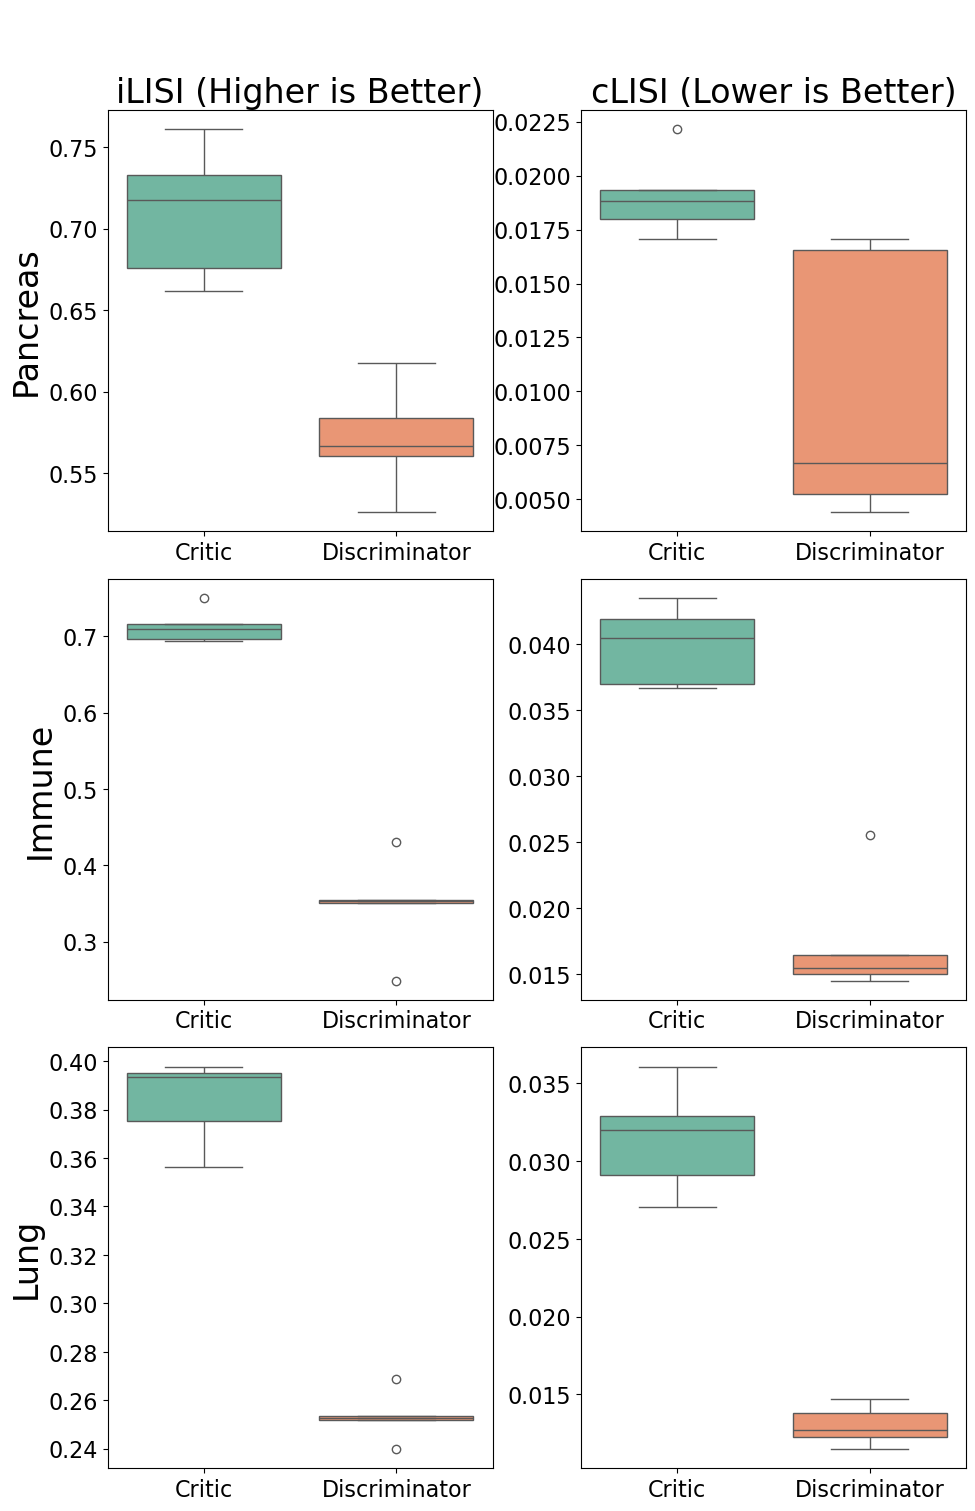

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. Define Dataset Files ---
results_dir = "results"
dataset_files = {
    "Pancreas": os.path.join(results_dir, "pancreas_binary_nested_cv_results.csv"),
    "Immune": os.path.join(results_dir, "immune_binary_nested_cv_results.csv"),
    "Lung": os.path.join(results_dir, "lung_binary_nested_cv_results.csv")
}
dataset_names = list(dataset_files.keys())

# --- 2. Check for Missing Files ---
missing_files = []
for title, filepath in dataset_files.items():
    if not os.path.exists(filepath):
        missing_files.append(filepath)

if missing_files:
    print("Error: Could not generate plot. The following result files are missing:")
    for f in missing_files:
        print(f"- {f}")
    print("\nPlease check the 'results' directory.")
else:
    print("Found all result files. Generating 3x2 (vertical) box plot...")
    
    # --- 3. Create the Figure ---
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    # --- 4. Loop Through Datasets and Plot ---
    for i, (title, filepath) in enumerate(dataset_files.items()):
        
        ax_ilisi = axes[i, 0] # Left column
        ax_clisi = axes[i, 1] # Right column
        
        # Load the data
        df = pd.read_csv(filepath)
        
        # Rename 'no_critic' to 'Discriminator'
        df['method'] = df['method'].replace({
            'no_critic': 'Discriminator',
            'critic': 'Critic'
        })
        
        # --- Plot iLISI (Left Column) ---
        sns.boxplot(
            data=df,
            x='method',
            y='ilisi',
            hue='method',
            ax=ax_ilisi,
            palette="Set2",
            legend=False,
            order=['Critic', 'Discriminator'] # Ensure consistent order
        )
        
        # --- Plot cLISI (Right Column) ---
        sns.boxplot(
            data=df,
            x='method',
            y='clisi',
            hue='method',
            ax=ax_clisi,
            palette="Set2",
            legend=False,
            order=['Critic', 'Discriminator']
        )

        # --- 5. Customize Subplots ---
        ax_ilisi.set_ylabel(title, fontsize=24)
        ax_clisi.set_ylabel("")
        
        # Set Y-axis limits to (0, 1)
        # ax_ilisi.set_ylim(0.0, 1.0)
        # ax_clisi.set_ylim(0.0, 0.05)
        
        # increase tick label size
        ax_ilisi.tick_params(axis='both', which='major', labelsize=16)
        ax_clisi.tick_params(axis='both', which='major', labelsize=16)
        
        # Set titles for the top row
        if i == 0:
            ax_ilisi.set_title("iLISI (Higher is Better)", fontsize=24)
            ax_clisi.set_title("cLISI (Lower is Better)", fontsize=24)
        else:
            ax_ilisi.set_title("")
            ax_clisi.set_title("")
            
        # Remove all X-axis labels ("Method")
        ax_ilisi.set_xlabel(None)
        ax_clisi.set_xlabel(None)

    # --- 6. Handle the Legend (CHANGED) ---
    # Get handles and labels from the first plot
    handles, labels = axes[0, 0].get_legend_handles_labels()
    
    # Add 'frameon=False' to remove the "strange square"
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.01),
               ncol=2,
               title=None,
               fontsize=12,
               frameon=False  # <-- THIS IS THE FIX
    )
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # --- 7. Save and Show the Final Figure ---
    output_filename = "ilisi_clisi_all_datasets_3x2_vertical_final.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    
    print(f"\nSuccessfully saved the final 3x2 plot as '{output_filename}'")
    
    # Show the plot inline in the notebook
    plt.show()

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import os

def calculate_paired_t_stats(a, b):
    """
    Performs a paired t-test and calculates CI for the mean difference.
    a = Critic scores, b = Discriminator scores
    """
    # Calculate the difference; positive value means 'a' (Critic) is higher
    diff = a - b
    
    # Perform the paired t-test
    t_stat, p_value = stats.ttest_rel(a, b)
    
    # Calculate mean difference
    mean_diff = np.mean(diff)
    
    # Calculate 95% CI for the mean difference
    dof = len(diff) - 1  # Degrees of freedom
    std_err_diff = stats.sem(diff) # Standard error of the mean of the differences
    
    # Get the CI (lower, upper)
    ci = stats.t.interval(0.95, dof, loc=mean_diff, scale=std_err_diff)
    ci_low = ci[0]
    ci_high = ci[1]
    
    return mean_diff, ci_low, ci_high, t_stat, p_value

def format_p_value(p_value):
    """
    Formats p-values to 6 decimal places, or '< 0.000001' if too small.
    """
    if p_value < 0.000001:
        return "< 0.000001"
    else:
        return f"{p_value:.6f}"

# --- 1. Define Dataset Files ---
results_dir = "results"
dataset_files = {
    "Pancreas": os.path.join(results_dir, "pancreas_binary_nested_cv_results.csv"),
    "Immune": os.path.join(results_dir, "immune_binary_nested_cv_results.csv"),
    "Lung": os.path.join(results_dir, "lung_binary_nested_cv_results.csv")
}
output_tex_file = "ttest_results.tex" # Define the output file name

# --- 2. Store all results for final table ---
table_rows = []

print("Running paired t-tests for all datasets...")

for title, filepath in dataset_files.items():
    if not os.path.exists(filepath):
        print(f"Warning: File not found {filepath}. Skipping...")
        continue
        
    df = pd.read_csv(filepath)
    
    # Rename for clarity
    df['method'] = df['method'].replace({'no_critic': 'Discriminator', 'critic': 'Critic'})
    
    # --- Pivot data to get paired scores ---
    # This aligns scores by 'fold' for the paired t-test
    ilisi_pivot = df.pivot(index='fold', columns='method', values='ilisi')
    clisi_pivot = df.pivot(index='fold', columns='method', values='clisi')
    
    # --- Calculate Stats for ILISI ---
    ilisi_critic_mean = np.mean(ilisi_pivot['Critic'])
    ilisi_critic_sd = np.std(ilisi_pivot['Critic'])
    ilisi_disc_mean = np.mean(ilisi_pivot['Discriminator'])
    ilisi_disc_sd = np.std(ilisi_pivot['Discriminator'])
    
    ilisi_stats = calculate_paired_t_stats(
        ilisi_pivot['Critic'], 
        ilisi_pivot['Discriminator']
    )
    
    # --- Calculate Stats for CLISI ---
    clisi_critic_mean = np.mean(clisi_pivot['Critic'])
    clisi_critic_sd = np.std(clisi_pivot['Critic'])
    clisi_disc_mean = np.mean(clisi_pivot['Discriminator'])
    clisi_disc_sd = np.std(clisi_pivot['Discriminator'])
    
    clisi_stats = calculate_paired_t_stats(
        clisi_pivot['Critic'], 
        clisi_pivot['Discriminator']
    )
    
    # --- Store formatted rows ---
    # --- UPDATED: \multicolumn to 7 columns ---
    table_rows.append(f"\\multicolumn{{7}}{{l}}{{\\textbf{{{title} Dataset}}}} \\\\")
    
    # --- UPDATED: Row format to include new stats ---
    table_rows.append(
        f"ILISI & {ilisi_critic_mean:.4f} ({ilisi_critic_sd:.4f}) & "
        f"{ilisi_disc_mean:.4f} ({ilisi_disc_sd:.4f}) & "
        f"{ilisi_stats[0]:.4f} & ({ilisi_stats[1]:.4f}, {ilisi_stats[2]:.4f}) & "
        f"{ilisi_stats[3]:.4f} & {format_p_value(ilisi_stats[4])} \\\\"
    )
    table_rows.append(
        f"CLISI & {clisi_critic_mean:.4f} ({clisi_critic_sd:.4f}) & "
        f"{clisi_disc_mean:.4f} ({clisi_disc_sd:.4f}) & "
        f"{clisi_stats[0]:.4f} & ({clisi_stats[1]:.4f}, {clisi_stats[2]:.4f}) & "
        f"{clisi_stats[3]:.4f} & {format_p_value(clisi_stats[4])} \\\\"
    )

# --- 3. Define LaTeX Table Structure ---
latex_header = [
    "\\begin{table}[h!]",
    "\\centering",
    "\\caption{Paired T-test Results (Critic vs. Discriminator)}",
    "\\label{tab:ttest_results}",
    # --- UPDATED: Column definition from 5 to 7 columns ---
    "\\begin{tabular*}{\\columnwidth}{@{\\extracolsep{\\fill}} l r r r l r r }",
    "\\toprule",
    # --- UPDATED: Header row to include new columns ---
    "Metric & Critic Mean (SD) & Disc. Mean (SD) & Mean Diff & 95\\% CI of Diff & t-stat & p-value \\\\",
    "\\midrule"
]

latex_footer = [
    "\\bottomrule",
    "\\end{tabular*}",
    "\\end{table}"
]

# --- 4. Combine and Write to File ---
final_latex_lines = []
final_latex_lines.extend(latex_header)

for i, row in enumerate(table_rows):
    final_latex_lines.append(row)
    # Add a midrule between datasets, but not after the last one
    if (i + 1) % 3 == 0 and (i + 1) < len(table_rows):
        final_latex_lines.append("\\midrule")
        
final_latex_lines.extend(latex_footer)

# Write the combined list to the file, joining with newlines
try:
    with open(output_tex_file, "w") as f:
        f.write("\n".join(final_latex_lines))
    print(f"\nSuccessfully wrote LaTeX table to '{output_tex_file}'")
    print(f"In your main .tex file, add: \\input{{{output_tex_file}}}")
except Exception as e:
    print(f"Error writing to file: {e}")

Running paired t-tests for all datasets...

Successfully wrote LaTeX table to 'ttest_results.tex'
In your main .tex file, add: \input{ttest_results.tex}
